# MNIST/Grass Mixed Image Data Analysis

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

## Mixing Model

To generate the mixed signal data, we employ a mixing model where:

$$ X = \gamma A + (1 - \gamma) B $$ 

where:

* $A$ is the MNIST data set,
* $B$ is grass image tiles (same dimensions as $A$), and
* $\gamma$ is a mixing parameter where $0 \le \gamma \le 1$.

For this exercise, we will use $\gamma = 0.2$, meaning that mixed data is comprised of:

* 80% grass tile data, and
* 20% MNIST.

Presumably, this should make for a sufficiently challenging problem.


In [2]:
Aimg, Alab = DU.load_data("data/mnist_70000.h5")
Bimg, Blab = DU.load_data("data/grass2.hdf5")

Ximg = Aimg * 0.2 + Bimg * 0.8
Xlab = Alab

## Raw Data

Here is a sample of the mixed data.  Each row corresponds to a MNIST digit category with various grass background tiles applied.

* Each row corresponds to an MNIST digit category.
* Each column corresponds to a source grass image.


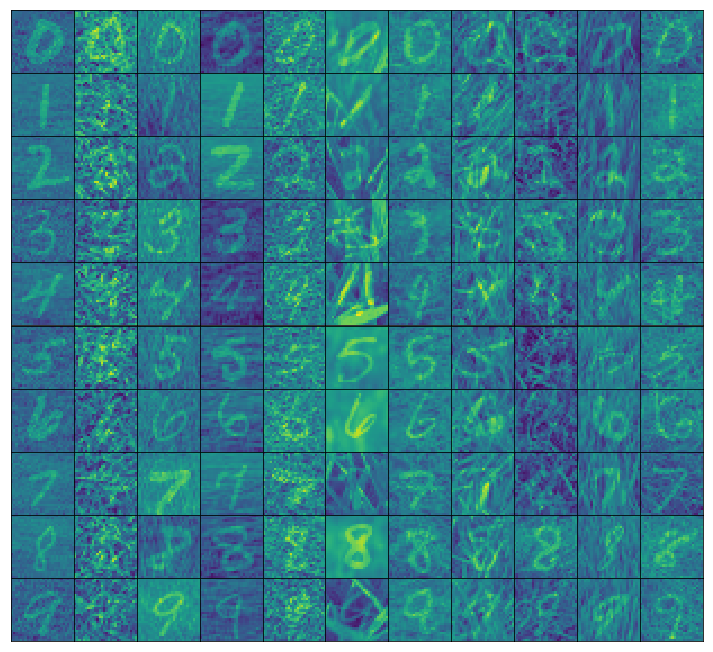

In [3]:
Agrouped = np.hstack([np.arange(70000)[Alab==i][0] for i in range(10)])
grouped = np.hstack([np.arange(70000)[(Alab==i) & (Blab==j)][0] for i in range(10) for j in range(11)])
DU.show_data(Ximg[grouped], cols=11)

## Principal Components

We perform singular value decomposition of the covariance matrix to determine the principal components of the data.

### Explanation of variance

The following graph shows the relative magnitude of each principal component, and how much total variance is explained by the first $k$ principal components.

In [4]:
X, Xbar, CX = DU.normalize_image_data(Ximg)

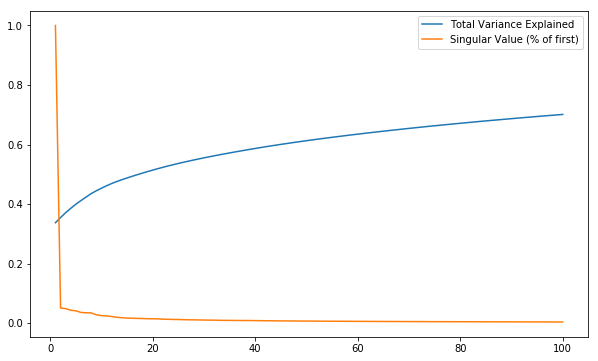

In [5]:
Xu, Xs, Xvt = np.linalg.svd(CX)
DU.graph_variance_explained(Xs)

* The first 50 principal components explain about 60% of the variance in the data.
* Additional principal components provide very modest gains in explaining more variance.

### Visualizing the Average Image

We have preprocessed our data to be zero mean across each pixel.

This is what the average image from this dataset looks like:

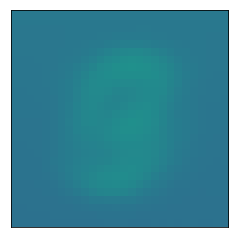

In [6]:
DU.show_img(DU.X_to_img(0, Xbar))

The average image has near-uniform intensity.

(Contrast with MNIST, where the average image looked more like a blurry digit.)

### Visualizing Principal Components

We can visualize each principal component as an image by rehaping the columns of $U$ to $28 \times 28$ and plotting them as images.

Because each PC constitutes a direction in pixel space, we view them with a diverging color scheme which makes it easy to see the positive and negative regions.

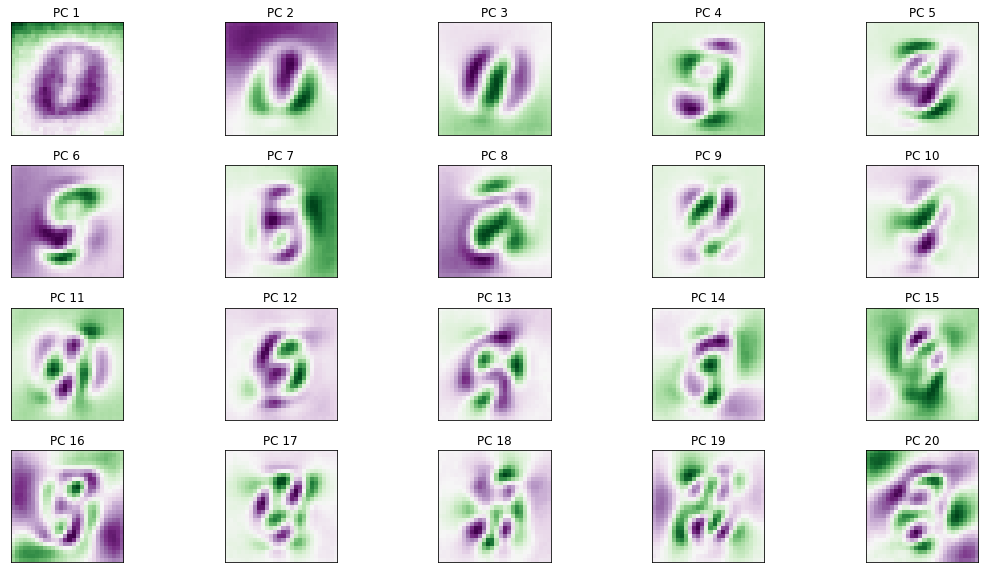

In [7]:
DU.show_pcs(Xu, 20)

The graph above shows the first 20 principal components.

* As with the MNIST data, we can see that the PCs begin simply, and increase in complexity.
* The PCs are clearly differ from the MNIST PCs (which were specialized for representing digits).
* These PCs are very general, and look suitable for representing almost any image (given enough of them).
* The patterns in these PCs resemble the basis of a 2-dimensional [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform), a basis often used in image compression.

### Determining the Subspace

We can attempt to visually estimate the dimension of the linear subspace for MNIST data by looking at dimensionally reduced images projected back into pixel space.

Here, we examine the quality of 20 random digits as they are projected into truncated PCA coordinates.

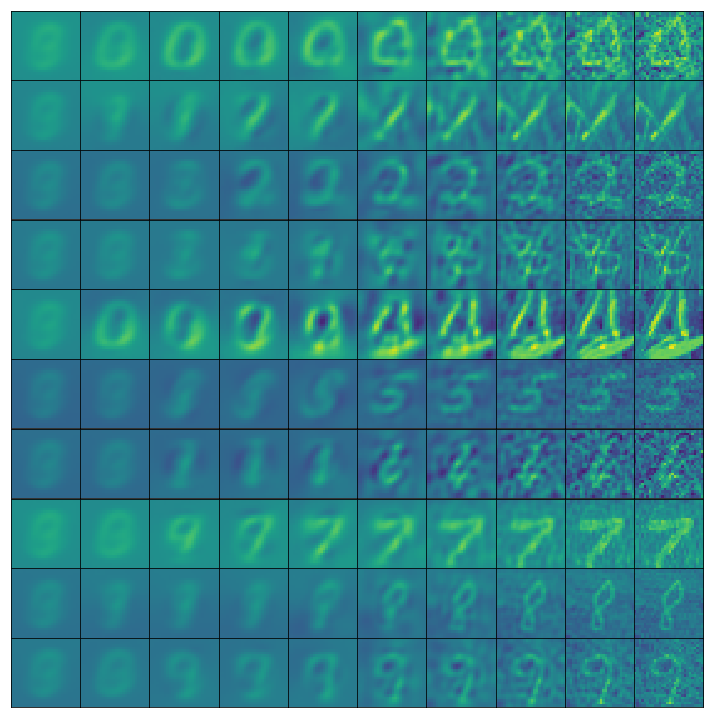

In [8]:
dims = [1, 2, 5, 10, 20, 50, 100, 200, 400, 784]

samp = X[Agrouped]
Psamp = [(samp @ Xu[:,:k]) @ Xu.T[:k,:] for k in dims]

pcadigits = np.asarray(Psamp).transpose((1,0,2))

DU.show_data(DU.X_to_img(np.vstack(pcadigits), Xbar), cols=10)

In the image above, each row represents an original data point, and each column represents a level of PCA dimension reduction.

**Observations:**

1. The images smoothly transition from uniform intensity, to blurry, to sharp.
2. In most cases, the MNIST digit is recognizable with 20-50 PCs.
3. It takes 100-200 PCs before the grass background sharpens into focus.

We characterize the effects of using a limited number of components (roughly) as follows:

| Dimension | % Variance | Description                                   |
| --------- | ---------- | --------------------------------------------- |
| 1         | 10%        | average illumination of image is established  |
| 10        | 50%        | light/dark regions appear within image        |
| 20        | 55%        | digit image starts to become recognizable     |
| 100+      | 65%        | identifiable grass texture begins to resolve  |
| 400+      | > 85%      | image becomes "sharp"                         |


## Embeddings

### PCA

We can look at the relationships between the most significant prinipal components by creating a scatterplot matrix.

Here, we show a scatterplot matrix of PC 1-5, with histograms on the diagonal.


### PCA with MNIST labels

First, we examine the SPLOM using labels based on the MNIST digit:

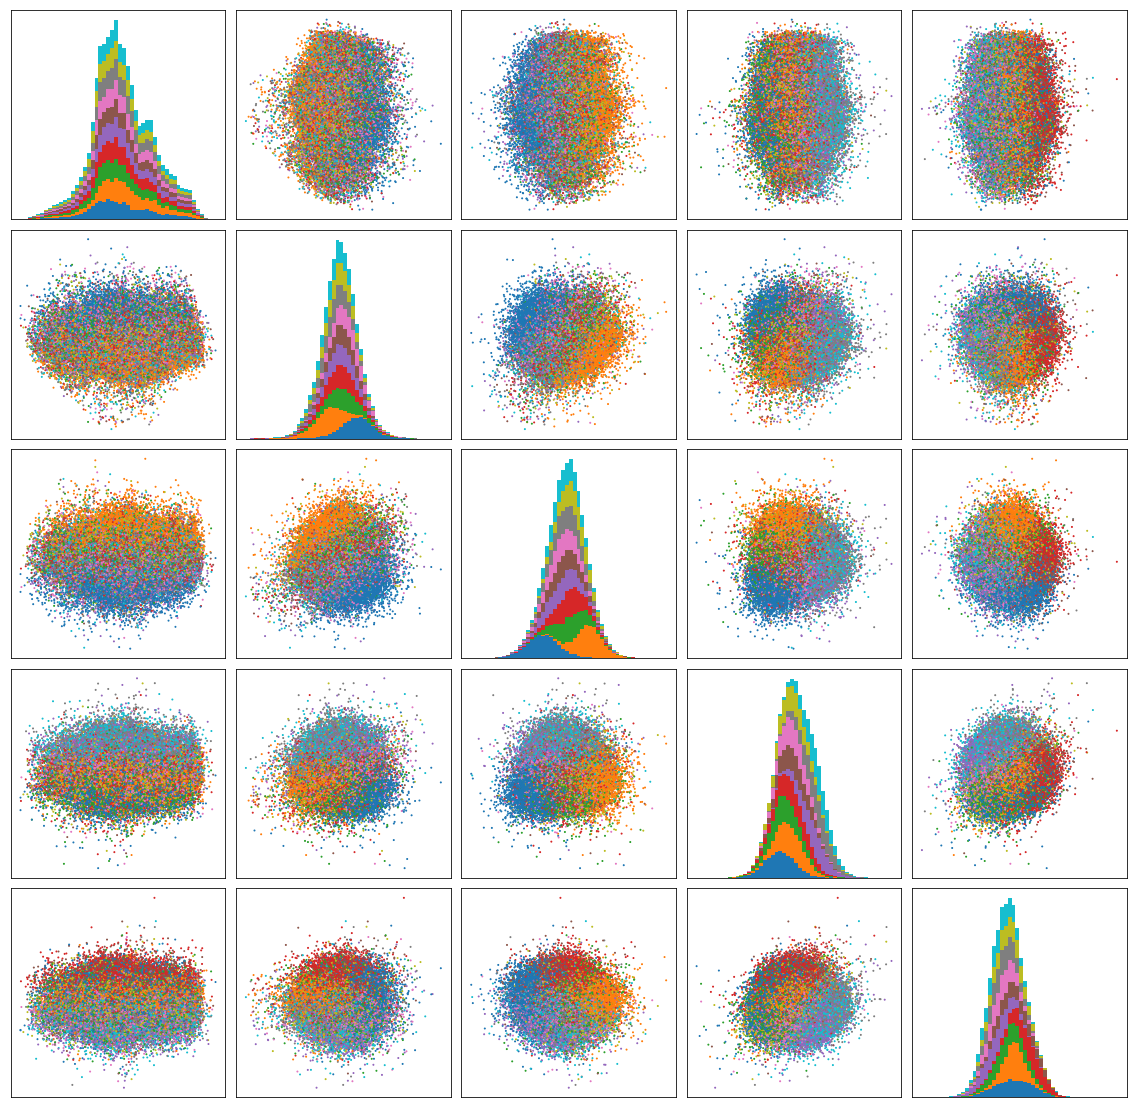

In [9]:
DU.show_splom(X @ Xu[:,:5], labels=Xlab, width=20)

### PCA with grass labels

Next, we view the same SPLOM with color labels based on the source grass image.

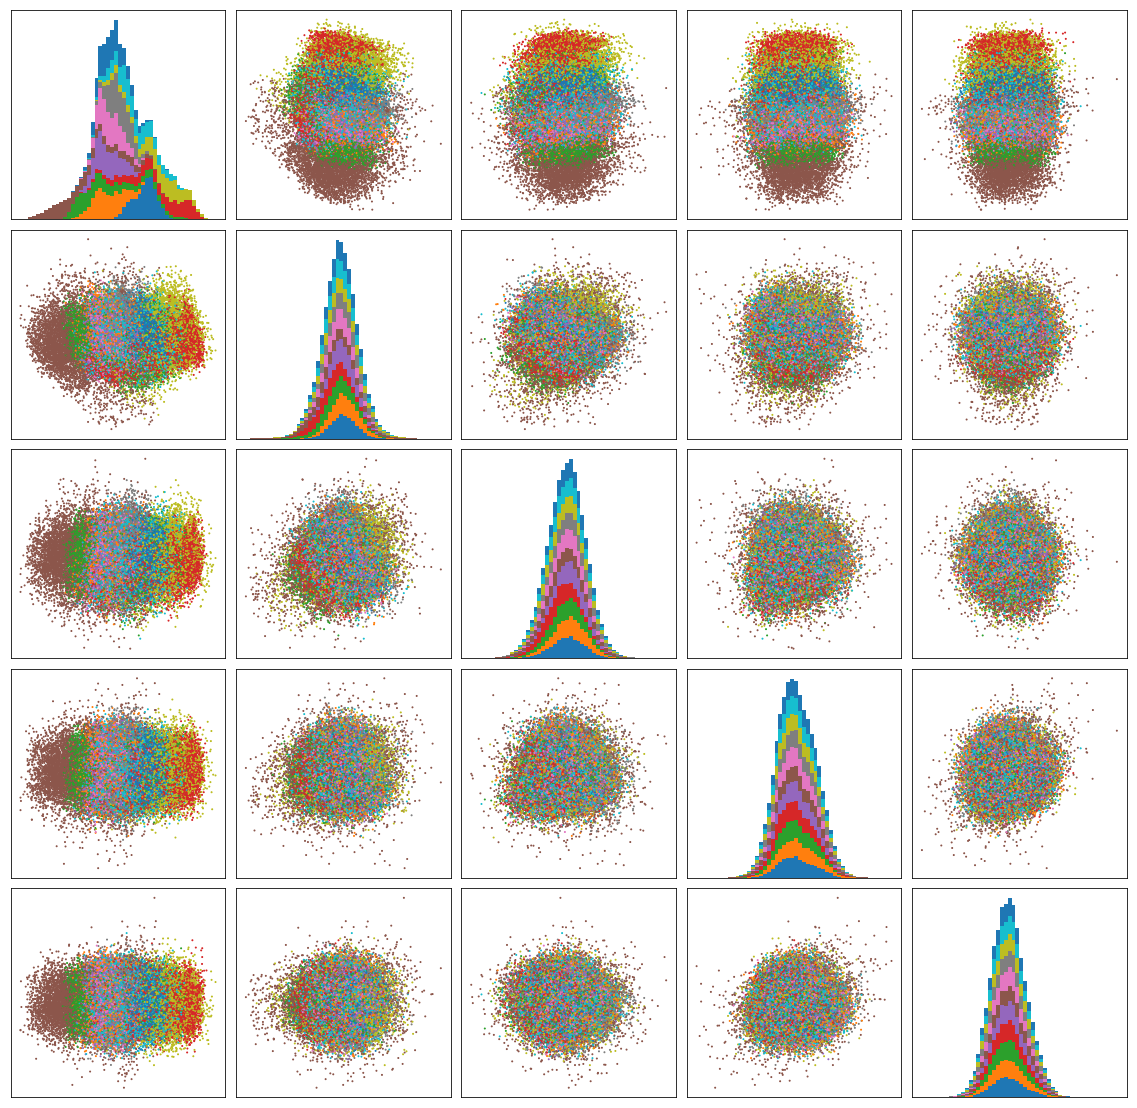

In [10]:
DU.show_splom(X @ Xu[:,:5], labels=Blab, width=20)

**Observations:**

1. PC1 varies most strongly with the grass source image.
2. PC2 and PC3 reveal slightly different distributions for the different MNIST digits.


### Isomap

We compare the Isomap embeddings of the data when projected into the first $k$ principal components.

Due to slow runtimes for Isomap on large datasets, we limit the number of points to `20,000`.

In [11]:
nsamp = 20000
Xsamp = X[:nsamp]

In [12]:
%cache isomap_mixed_pca5 = DU.isomap_embedding(Xsamp @ Xu[:,:5])
%cache isomap_mixed_pca10 = DU.isomap_embedding(Xsamp @ Xu[:,:10])
%cache isomap_mixed_pca20 = DU.isomap_embedding(Xsamp @ Xu[:,:20])
%cache isomap_mixed_pca50 = DU.isomap_embedding(Xsamp @ Xu[:,:50])
%cache isomap_mixed_pca100 = DU.isomap_embedding(Xsamp @ Xu[:,:100])
%cache isomap_mixed_all = DU.isomap_embedding(Xsamp)

loading cached value for variable 'isomap_mixed_pca5'. Time since pickling  2 days, 21:34:28.254499
loading cached value for variable 'isomap_mixed_pca10'. Time since pickling  2 days, 21:28:39.240771
loading cached value for variable 'isomap_mixed_pca20'. Time since pickling  2 days, 21:22:39.746855
loading cached value for variable 'isomap_mixed_pca50'. Time since pickling  2 days, 21:16:16.742626
loading cached value for variable 'isomap_mixed_pca100'. Time since pickling  2 days, 21:09:33.099694
loading cached value for variable 'isomap_mixed_all'. Time since pickling  2 days, 20:55:44.240822


### Isomap with MNIST labels

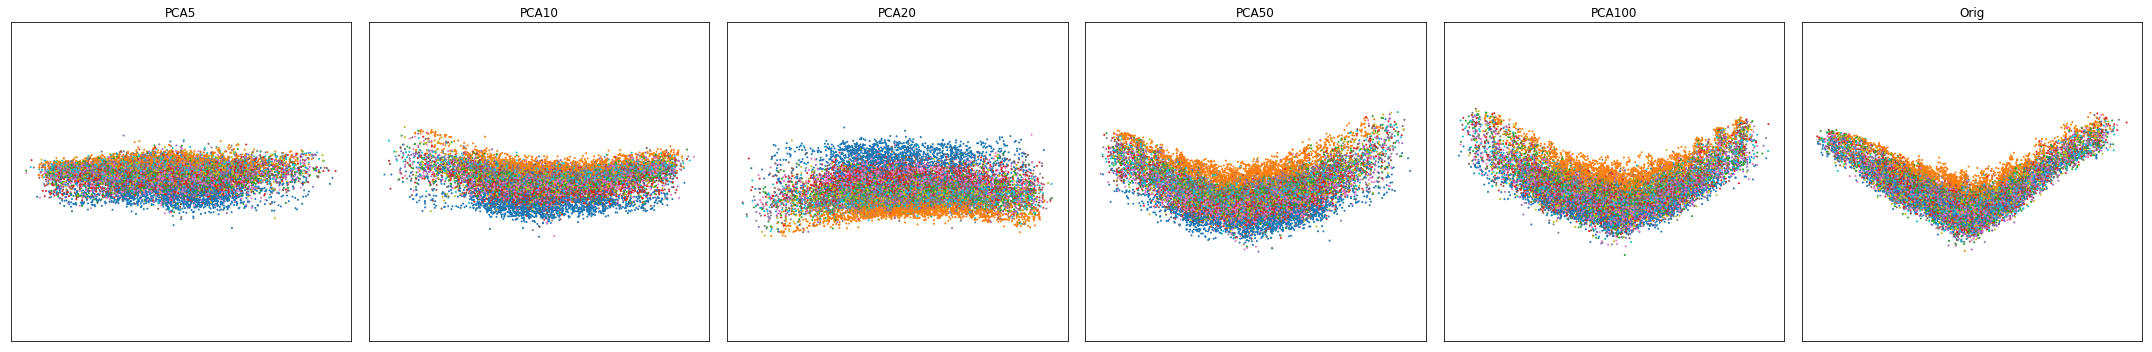

In [13]:
DU.show_embeddings(
    [isomap_mixed_pca5, isomap_mixed_pca10, isomap_mixed_pca20, isomap_mixed_pca50, isomap_mixed_pca100, isomap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

### Isomap with Grass labels

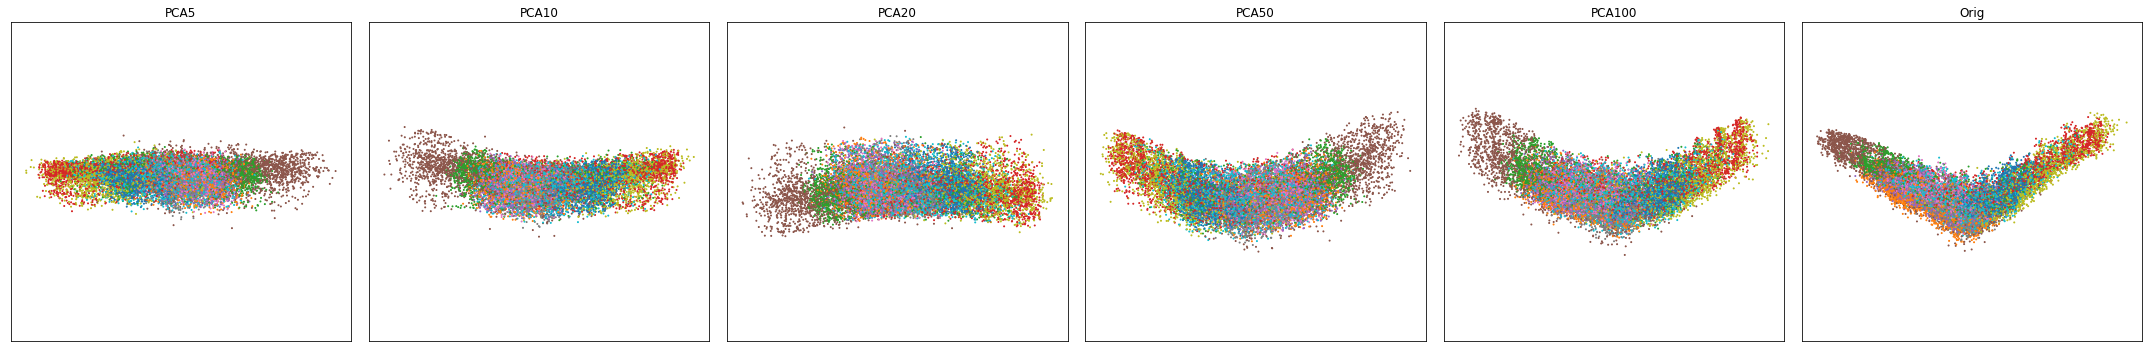

In [14]:
DU.show_embeddings(
    [isomap_mixed_pca5, isomap_mixed_pca10, isomap_mixed_pca20, isomap_mixed_pca50, isomap_mixed_pca100, isomap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab[:nsamp]
)

**Observations:**

1. The upper images show long horizontal bands which roughly correspond to the different MNIST digit categories.
2. The lower images reveal short vertical bands which (very) roughly correspond to the source grass image label.


### Student-T Stochastic Neighbor (t-SNE)



In [18]:
%cache tsne_mixed_pca5 = DU.tsne_embedding(X @ Xu[:,:5])
%cache tsne_mixed_pca10 = DU.tsne_embedding(X @ Xu[:,:10])
%cache tsne_mixed_pca20 = DU.tsne_embedding(X @ Xu[:,:20])
%cache tsne_mixed_pca50 = DU.tsne_embedding(X @ Xu[:,:50])
%cache tsne_mixed_pca100 = DU.tsne_embedding(X @ Xu[:,:100])
%cache tsne_mixed_all = DU.tsne_embedding(X)

loading cached value for variable 'tsne_mixed_pca5'. Time since pickling  2 days, 19:56:58.677380
loading cached value for variable 'tsne_mixed_pca10'. Time since pickling  2 days, 19:40:19.329676
loading cached value for variable 'tsne_mixed_pca20'. Time since pickling  2 days, 19:18:03.346204
loading cached value for variable 'tsne_mixed_pca50'. Time since pickling  2 days, 18:57:24.848637
loading cached value for variable 'tsne_mixed_pca100'. Time since pickling  2 days, 18:30:14.142949
loading cached value for variable 'tsne_mixed_all'. Time since pickling  2 days, 16:31:45.697000


### t-SNE with MNIST labels

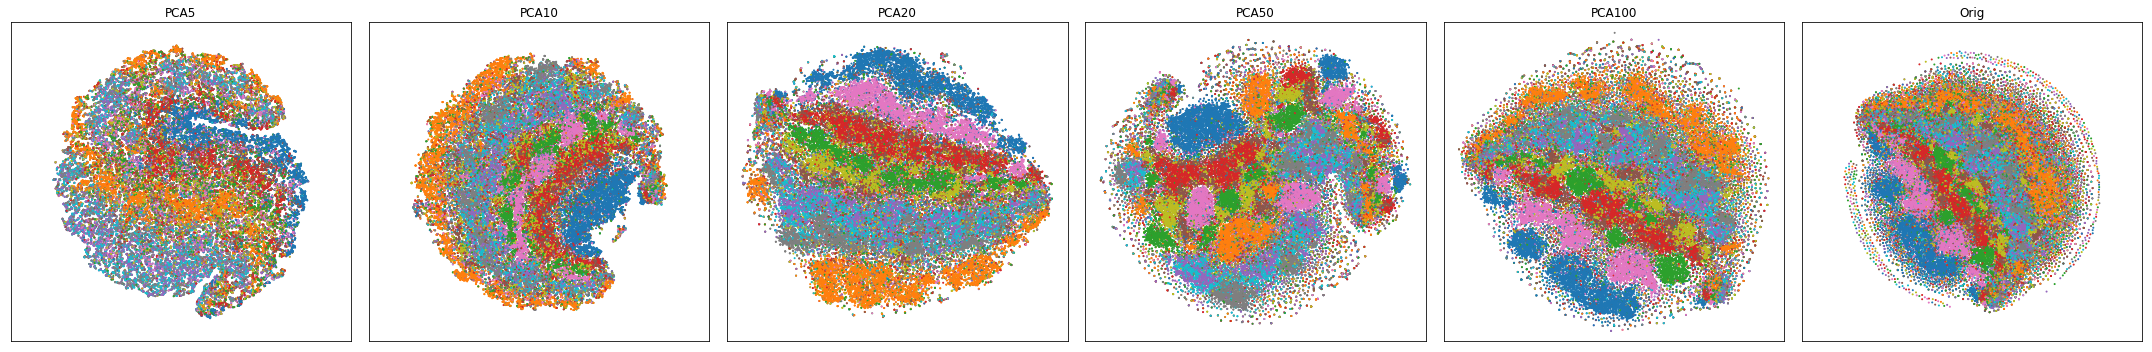

In [19]:
DU.show_embeddings(
    [tsne_mixed_pca5, tsne_mixed_pca10, tsne_mixed_pca20, tsne_mixed_pca50, tsne_mixed_pca100, tsne_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

### t-SNE with Grass labels

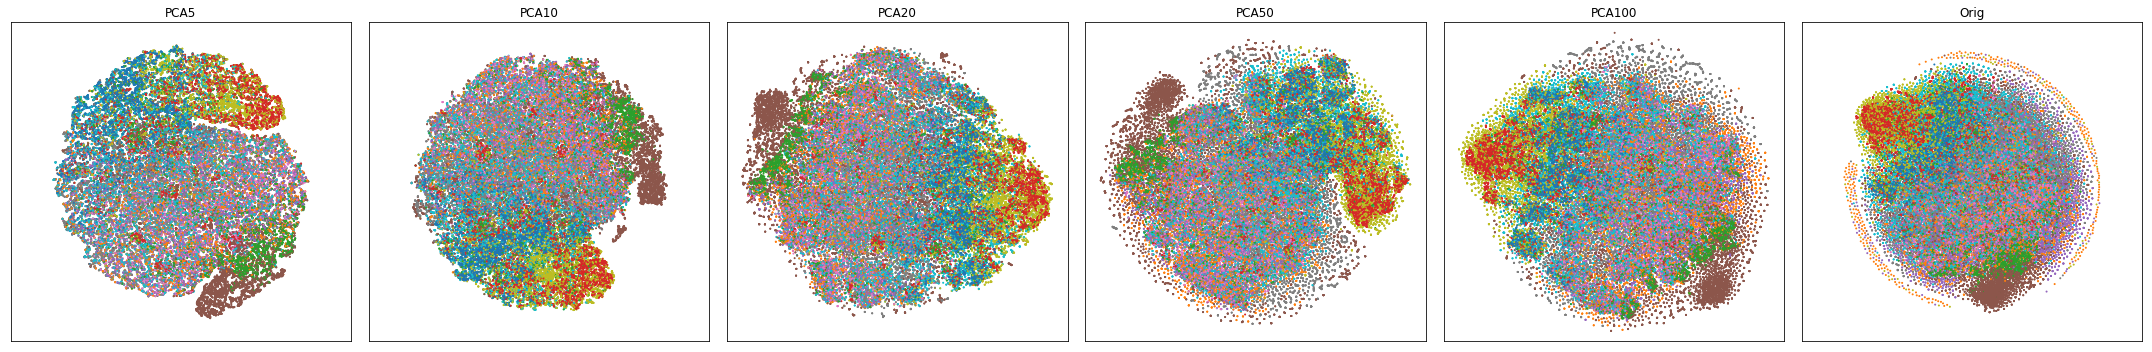

In [20]:
DU.show_embeddings(
    [tsne_mixed_pca5, tsne_mixed_pca10, tsne_mixed_pca20, tsne_mixed_pca50, tsne_mixed_pca100, tsne_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab
)

**Observations:**

1. There are strong clumps/bands where common MNIST digits are grouped together.
2. This effect is strongest using 20-100 PCA dimensions.
3. In the lower images, we can see that the manifold is elongated between two extremes red/brown.
4. This red/brown direction (based on grass image) is essentially orthogonal to the bands of digit groupings in the upper images.


### Uniform Manifold Approximation and Projection (UMAP)

Here, we look at same PCA projections of the data using UMAP.

In [21]:
%cache umap_mixed_pca5 = DU.umap_embedding(X @ Xu[:,:5], n_neighbors=30)
%cache umap_mixed_pca10 = DU.umap_embedding(X @ Xu[:,:10], n_neighbors=30)
%cache umap_mixed_pca20 = DU.umap_embedding(X @ Xu[:,:20], n_neighbors=30)
%cache umap_mixed_pca50 = DU.umap_embedding(X @ Xu[:,:50], n_neighbors=30)
%cache umap_mixed_pca100 = DU.umap_embedding(X @ Xu[:,:100], n_neighbors=30)
%cache umap_mixed_all = DU.umap_embedding(X, n_neighbors=30)

loading cached value for variable 'umap_mixed_pca5'. Time since pickling  2 days, 21:58:11.743313
loading cached value for variable 'umap_mixed_pca10'. Time since pickling  2 days, 21:56:38.398728
loading cached value for variable 'umap_mixed_pca20'. Time since pickling  2 days, 21:54:57.844481
loading cached value for variable 'umap_mixed_pca50'. Time since pickling  2 days, 21:53:10.579062
loading cached value for variable 'umap_mixed_pca100'. Time since pickling  2 days, 21:51:20.902027
loading cached value for variable 'umap_mixed_all'. Time since pickling  2 days, 21:49:05.843985


### UMAP with MNIST labels

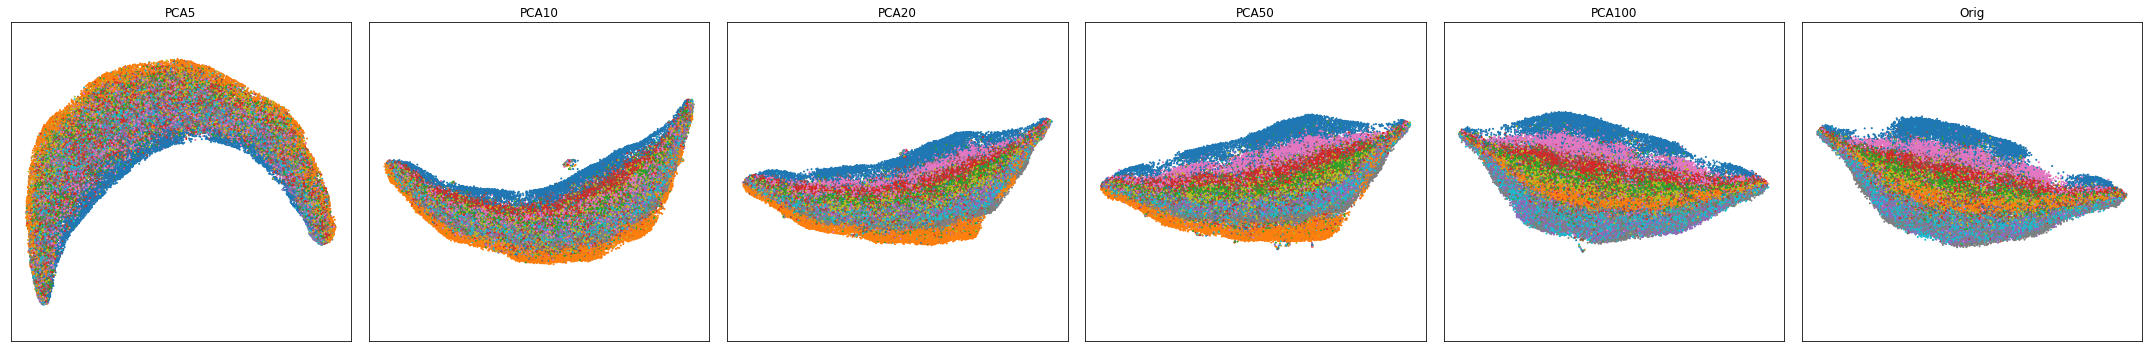

In [22]:
DU.show_embeddings(
    [umap_mixed_pca5, umap_mixed_pca10, umap_mixed_pca20, umap_mixed_pca50, umap_mixed_pca100, umap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

### UMAP with Grass labels

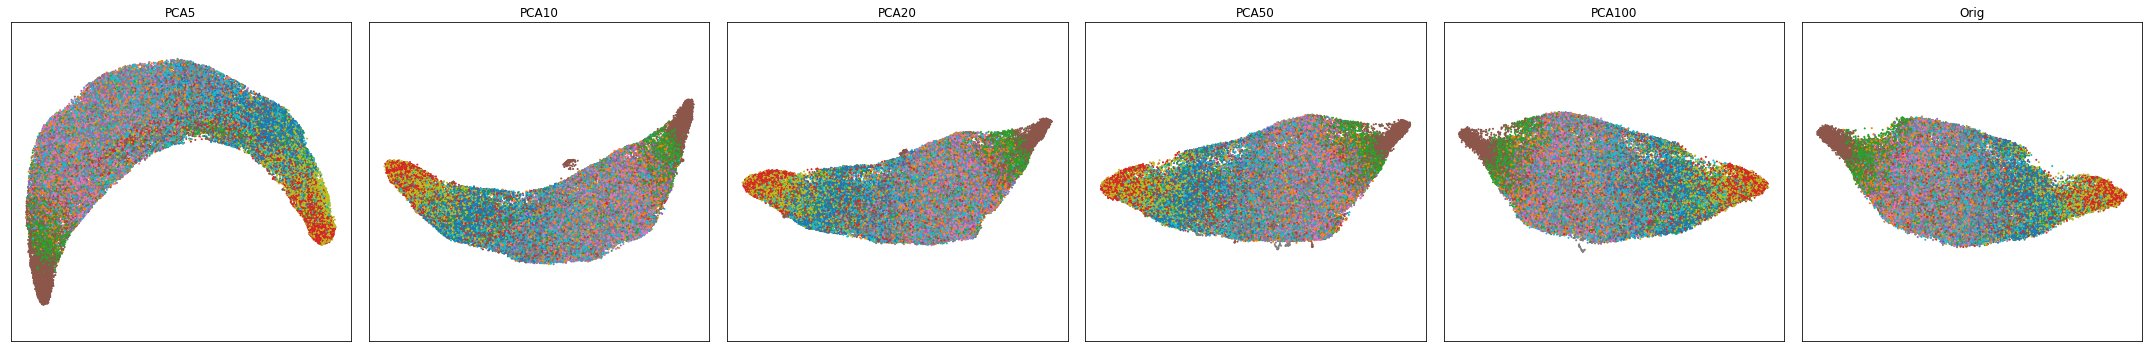

In [23]:
DU.show_embeddings(
    [umap_mixed_pca5, umap_mixed_pca10, umap_mixed_pca20, umap_mixed_pca50, umap_mixed_pca100, umap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab
)

**Observations:**

1. UMAP shows a picture very similar to Isomap, with horizontal bands corresponding to MNIST digit, and vertical bands corresponding to source grass image.
2. The banding effects for grass source image do not appear as strongly here as they do in Isomap.


## Conclusions

Using multiple techniques, we can see that the manifold for the mixed signal contains some directions that have mostly do with the source grass image, and other directions that are more related to the MNIST digit category.

The manifold is elongated in a direction that more closely corresponds to the grass labels.  It's embedded shape is somewhat similar to the grass embedding, but is thicker/fatter.

In [24]:
%cache